# Project 02: Plan your trip to the 35 top cities in France
## Bloc n°1 - Jedha - dsmft - Paris14
### Nicolas Hegerle

## Library imports

### <ins>Import the necessary libraries
* functions are defined in independant python scripts

In [3]:
import pandas as pd

import plotly.io as pio
import plotly.express as px
pio.renderers.default = "vscode"

pd.set_option('display.max_columns', None)

from compute_winner import compute_winners

## Upload hotel info

In [2]:
# load hotel information for the top cities
df_all_hotels = pd.read_json("data_files/city_hotels.json", encoding='utf-8')


## Calculate the top cities to travel to based on the weather preferences

In [3]:
# relative importance attributed to the different weather features
rel_importance = {
        'humidity': 1,
        'wind_sp': 1,
        'cloudiness': 1,
        'uv_index': 1,
        'day_temp': 1,
        'day_temp_feels': 1,
        'rain': -1
                }
# nb top cities we want to return
nb_cities = 5

# return the dataframe of the top cities and all cities
df_all_city_scores, df_top_city_scores = compute_winners(rel_importance, nb_cities)

# get hotels only for top cities
mask = pd.Series([True if (city in df_top_city_scores['city_name'].tolist()) else False for city in df_all_hotels['location']])
df_top_city_hotels = df_all_hotels.loc[mask]
df_top_city_hotels.to_csv("data_files/top_city_hotels.csv", index=False)

# generate the dataframe containing all the data
# for each day forcasted will be associated each hotel for each city
df_holiday_data = df_all_city_scores.merge(df_all_hotels, left_on = 'city_name', right_on = 'location', suffixes = ('_c', '_h'))
df_holiday_data.drop('location', axis = 1, inplace = True)
df_holiday_data.to_csv("data_files/all_data.csv", index = False)


Based on your preferences the top 5 cities to travel to over the next 7 days seem to be:
               Collioure
                 Bayonne
                  Cassis
Saintes Maries de la mer
      Bormes les Mimosas


## Plot the top cities on a map

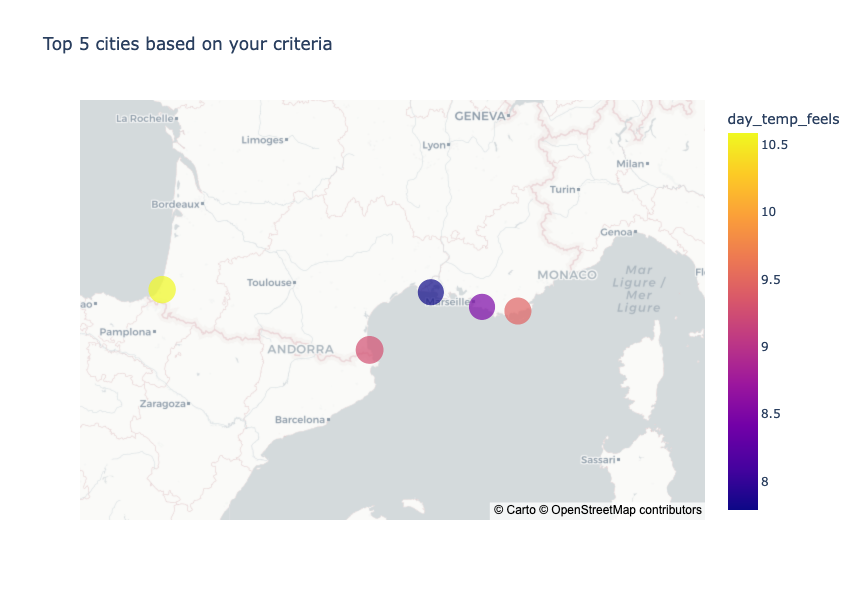

In [4]:
hover_show_city = ['score_total', 'day_temp_feels', 'rain', 'uv_index']
hover_data = {col:True if col in hover_show_city else False for col in df_top_city_scores.columns}

center_lat = df_top_city_scores['lat'].mean()
center_lon = df_top_city_scores['lon'].mean()
center = {'lat' : center_lat, 'lon' : center_lon}

fig = px.scatter_mapbox(
        df_top_city_scores, 
        lat = 'lat', 
        lon = 'lon', 
        color = 'day_temp_feels', 
        size = 'day_temp', 
        zoom = 5, 
        mapbox_style='carto-positron', 
        width=700, height=600, 
        hover_name = 'city_name', hover_data = hover_data, 
        title = f'Top {nb_cities} cities based on your criteria', 
        center = center
)

#fig.update_layout(showlegend = False)
fig.show()

## Plot the top hotels for the top cities on a map

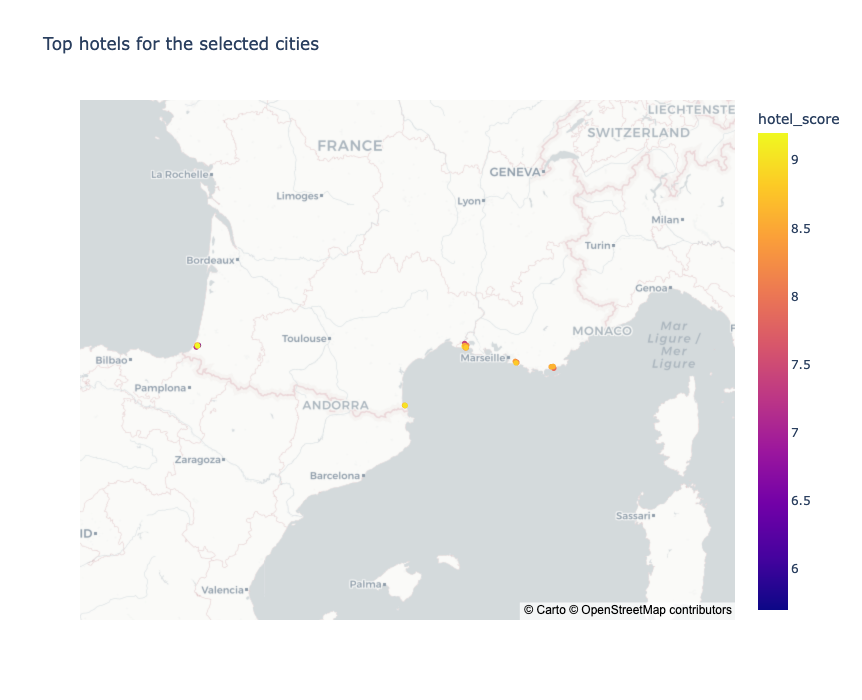

In [5]:
hover_show_hotel = ['location', 'hotel_score', 'score_title', 'score_expe', 'url']
hover_data = {col:True if col in hover_show_hotel else False for col in df_top_city_hotels.columns}

center_lat = df_top_city_hotels['hotel_lat'].mean()
center_lon = df_top_city_hotels['hotel_lon'].mean()
center = {'lat' : center_lat, 'lon' : center_lon}

fig = px.scatter_mapbox(
        df_top_city_hotels,
        lat = "hotel_lat", 
        lon = "hotel_lon", 
        color = 'hotel_score', 
        zoom = 5, 
        mapbox_style="carto-positron", 
        width=800, 
        height=700, 
        hover_name = "hotel_name", 
        hover_data=hover_data, title='Top hotels for the selected cities', 
        center = center
)

fig.update_layout(showlegend = True)
fig.show()


## Upload data to AWS S3 and make it available in SQL database

### <ins>Upload to AWS S3 bucket</ins>

In [1]:
# specific library import for AWS S3 buckets and RDS
import boto3
from private import *
from sqlalchemy import create_engine
import psycopg2

In [12]:
# AWS credentials
ACCESS_KEY = aws_access_key_id
SECRET_KEY = aws_secret_access_key

bucket_name = "plan-trip-nhe"
key = "hotel_city_weather_info.csv"
body = "data_files/all_data.csv"
bucket_region = "eu-west-2"

In [11]:
#Boto3 session set-up
session = boto3.Session(aws_access_key_id=ACCESS_KEY, 
                        aws_secret_access_key=SECRET_KEY)

#Set-up an S3 bucket and dump csv file
s3 = session.resource("s3")
bucket = s3.create_bucket(Bucket = bucket_name, CreateBucketConfiguration={'LocationConstraint': bucket_region})

# put the desired file in the bucket
put_object = bucket.put_object(Key = key, Body = body)

### <ins>Make data available through AWS RDS database</ins>

In [4]:
#Creates the engine to establish connection between the postgres db and python
engine = create_engine(f'postgresql+psycopg2://{login}:{kw}@{endpoint}:5432/postgres', echo=True)
df_all = pd.read_csv("data_files/all_data.csv")
df_all.to_sql('hotel_city_weather', engine, if_exists = 'replace', index= False)


2022-01-14 11:34:35,681 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2022-01-14 11:34:35,682 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-01-14 11:34:35,702 INFO sqlalchemy.engine.Engine select current_schema()
2022-01-14 11:34:35,703 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-01-14 11:34:35,720 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2022-01-14 11:34:35,721 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-01-14 11:34:35,740 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2022-01-14 11:34:35,741 INFO sqlalchemy.engine.Engine [generated in 0.00067s] {'name': 'hotel_city_weather'}
2022-01-14 11:34:35,770 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-01-14 11:34:35,771 INFO sqlalchemy.engine.Engine 
CREATE TABLE hotel_city_weather (
	city_id BIGINT, 
	date_updated_c TEXT, 
	lat FLOAT(53), 
	lon FLOAT(53), 
	city_name TEX